# High level insight on genetic variations
Note: As this is my first published Kernel, am open to suggestions. If this helped you, some upvotes would be very much appreciated.

### Library and Settings

Import required library and define constants

In [3]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### Files

In [4]:
for f in os.listdir('input'):
    size_bytes = round(os.path.getsize('input/' + f)/ 1000, 2)
    size_name = ["KB", "MB"]
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    print(f.ljust(20) + str(s).ljust(7) + size_name[i])

stage1_solution_filtered.csv8.46   KB
stage2_sample_submission.csv21.65  KB
stage2_test_text.csv59.15  MB
stage2_test_variants.csv16.25  KB
submission_xgb_09_28_22_31_16.csv147.45 KB
test_text           313.3  MB
test_variants       93.36  KB
training_text       207.15 MB
training_variants   66.69  KB


Training data size is smaller than testing counterpart.

### Sneak Peak of data

Load training and testing data. Have a quick look at columns, its shape and values

In [5]:
train_variants_df = pd.read_csv("input/training_variants")
test_variants_df = pd.read_csv("input/test_variants")
train_text_df = pd.read_csv("input/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv("input/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


We have more samples of test data than training data. As mentioned in data introduction, some of the test data is machine-generated to prevent hand labelling.

In [6]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
print("For training data, there are a total of", len(train_variants_df.ID.unique()), "IDs,", end='')
print(len(train_variants_df.Gene.unique()), "unique genes,", end='')
print(len(train_variants_df.Variation.unique()), "unique variations and ", end='')
print(len(train_variants_df.Class.unique()),  "classes")

For training data, there are a total of 3321 IDs,264 unique genes,2996 unique variations and 9 classes


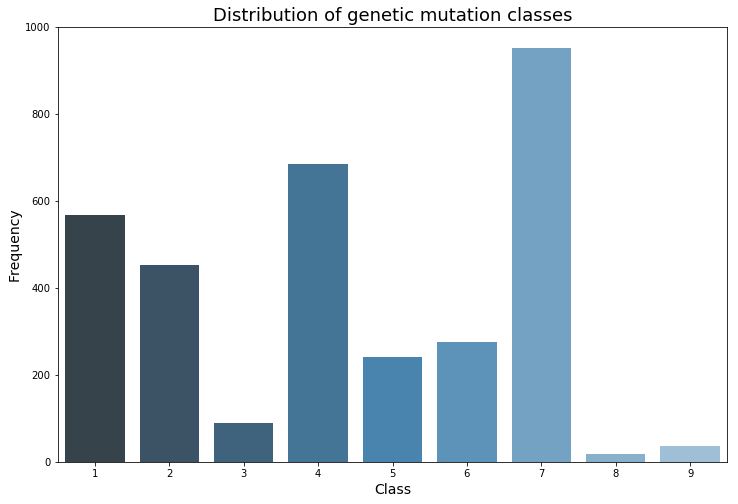

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_variants_df, palette="Blues_d")
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

In [10]:
gene_group = train_variants_df.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences", minimal_occ_genes)

Genes with maximal occurences Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


Lets have a look at some genes that has highest number of occurrences in each class

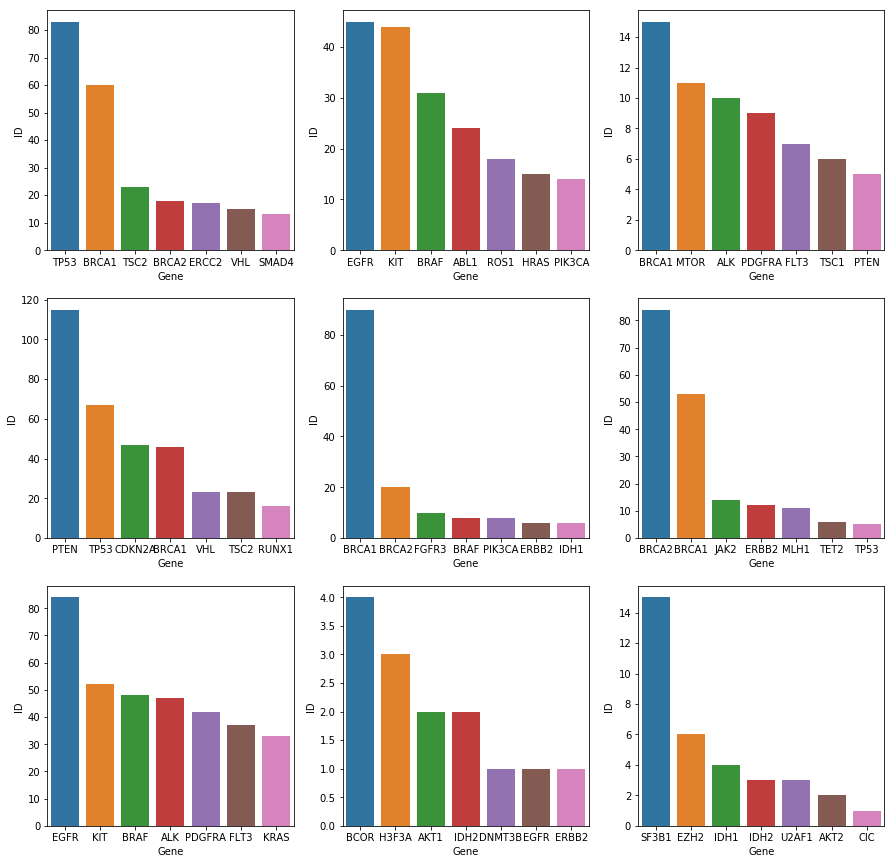

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

Some points we can conclude from these graphs:

BRCA1 is highly dominating Class 5  
SF3B1 is highly dominating Class 9  
BRCA1 and BRCA2 are dominating Class 6  

### Lets get some insight on text data

In [12]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
train_text_df.loc[:, 'Text_count']  = train_text_df["Text"].apply(lambda x: len(x.split()))
train_text_df.head()

,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5722
2,2,Abstract Background Non-small cell lung canc...,5722
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


Let us combine both dataframes for further use

In [14]:
train_full = train_variants_df.merge(train_text_df, how="inner", left_on="ID", right_on="ID")
train_full[train_full["Class"]==1].head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cord鈥搒tromal tumors and germ-cell tumors a...,2710
38,38,DICER1,D1709A,1,Sex cord鈥搒tromal tumors and germ-cell tumors a...,2710


There are multiple rows with similar texts let us check how many of them are unique and whether all similar texts belongs to same class

In [15]:
count_grp = train_full.groupby('Class')["Text_count"]
count_grp.describe()

Class       
1      count      568.000000
       mean      9444.545775
       std       6513.469240
       min          1.000000
       25%       4970.000000
       50%       7286.500000
       75%      12868.250000
       max      52969.000000
2      count      452.000000
       mean      9306.261062
       std       7624.222077
       min        116.000000
       25%       4184.250000
       50%       6810.000000
       75%      12209.500000
       max      61923.000000
3      count       89.000000
       mean      6751.123596
       std       3724.401696
       min       1737.000000
       25%       4283.000000
       50%       5572.000000
       75%       7415.000000
       max      27371.000000
4      count      686.000000
       mean      8978.188047
       std       7276.221057
       min         53.000000
       25%       4566.000000
       50%       6351.000000
                    ...     
6      std       3827.958077
       min          1.000000
       25%       4505.500000
 

We can see there are some entries with text count of 1. Lets have a look at those entries

In [16]:
train_full[train_full["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,null,1
1277,1277,ARID5B,Truncating Mutations,1,null,1
1407,1407,FGFR3,K508M,6,null,1
1639,1639,FLT1,Amplification,6,null,1
2755,2755,BRAF,G596C,7,null,1


In [17]:
train_full[train_full["Text_count"]<500.0]

,ID,Gene,Variation,Class,Text,Text_count
140,140,EGFR,I491M,5,The accurate determination of perfluoroalkyl s...,430
145,145,EGFR,K467T,2,The accurate determination of perfluoroalkyl s...,430
259,259,EGFR,S464L,2,The accurate determination of perfluoroalkyl s...,430
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,228
692,692,CDKN2A,G93W,4,Cell division is controlled by a series of pos...,228
693,693,CDKN2A,V118D,4,Cell division is controlled by a series of pos...,228


As we can see there are some entries without any text data. Now let us get distribution of text count for each class

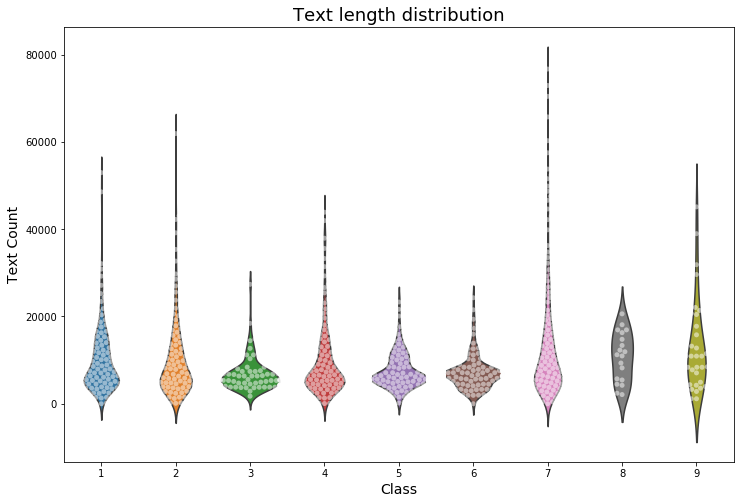

In [18]:
plt.figure(figsize=(12,8))
gene_count_grp = train_full.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=train_full, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=train_full, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

Distribution looks quite interesting and now I am in love with violin plots. All classes have most counts in between 0 to 20000. Just as expected. There should be some

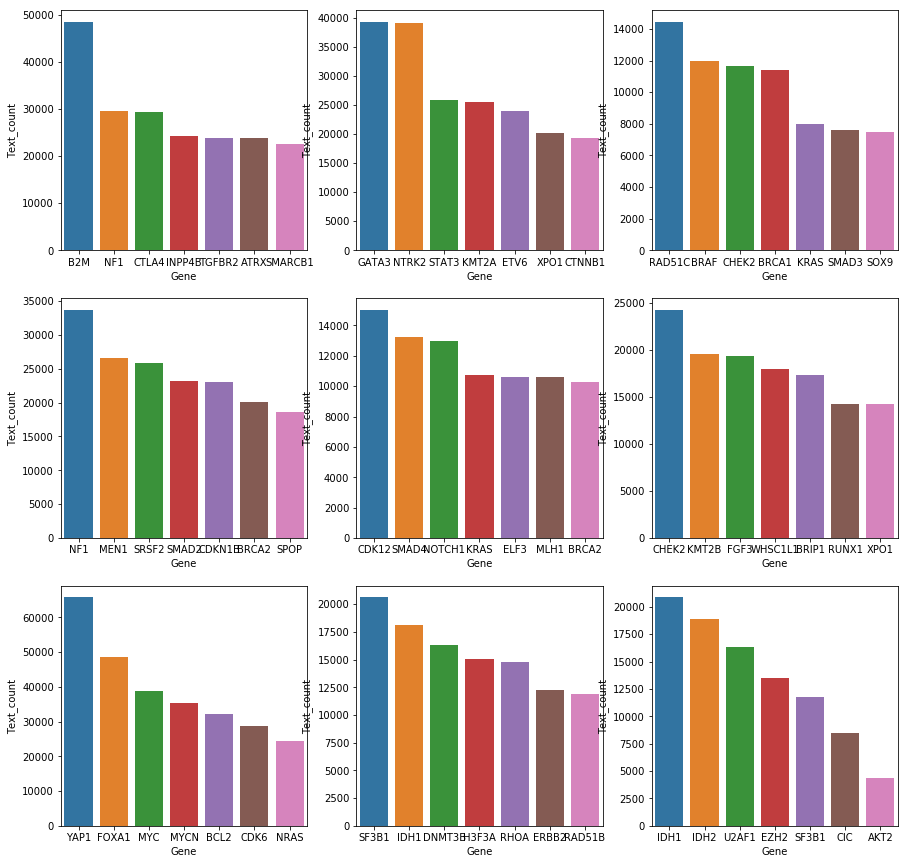

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_full[train_full["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

Frequently occurring terms for each class

We need to know more about text. Tf-idf is known as one good technique to use for text transformation and get good features out of text for training our machine learning model. Here you can find more details about tf-idf and some useful code snippets.

In [20]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

Lets plot out some top features we got using Tf-Idf for each class

In [21]:
tfidf = TfidfVectorizer(
	min_df=5, max_features=16000, strip_accents='unicode',lowercase =True,
	analyzer='word', token_pattern=r'\w+', use_idf=True, 
	smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(train_full["Text"])

Xtr = tfidf.fit_transform(train_full["Text"])
y = train_full["Class"]
features = tfidf.get_feature_names()
top_dfs = top_feats_by_class(Xtr, y, features)

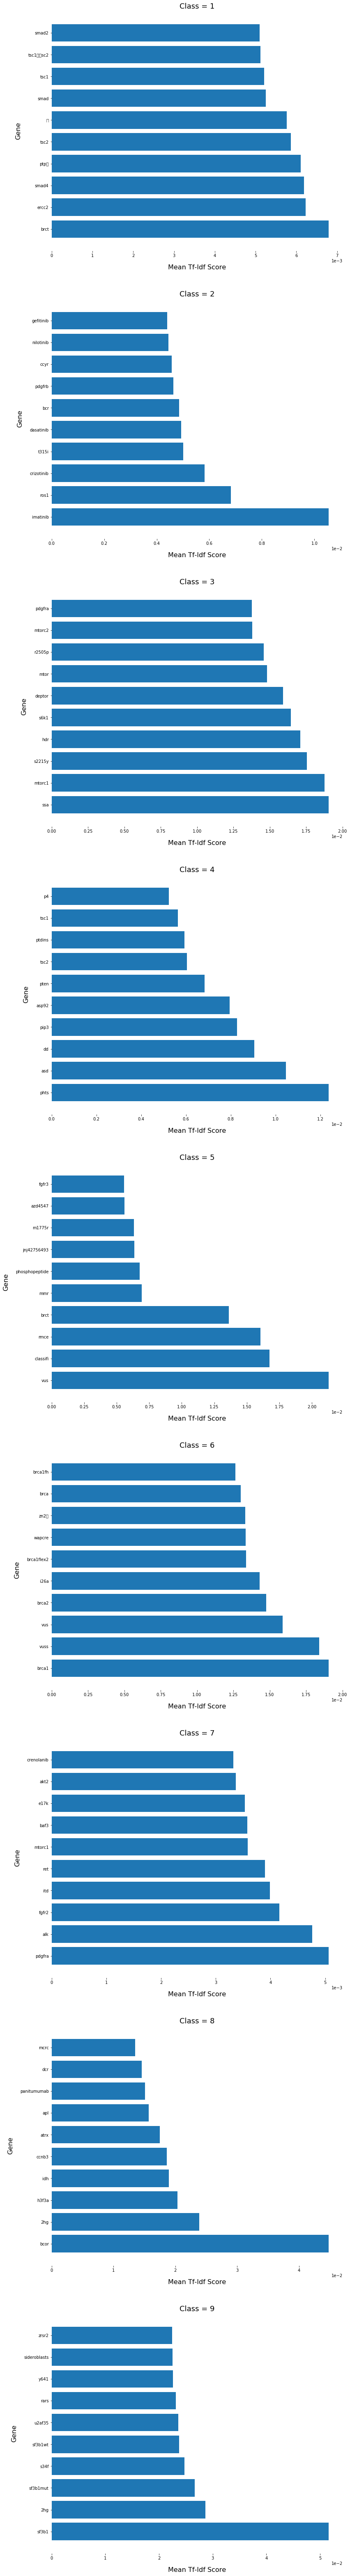

In [22]:
plot_tfidf_classfeats_h(top_dfs)